UFABC - Redes sem Fio - Prof. Dr. Carlo Kleber

# Transmissão sem Fio

| Nome                        | RA          |
|-----------------------------|-------------|
| Adinan Alves de Brito Filho | 11201920527 |
| Bruno Melati Kuvasney       | 11202021334 |
| Fernando Hsiao              | 11202231201 |
| Gustavo Diogo Silva         | 11201920321 |
| Marcos Vinicius Mira        | 11201721404 |
| Vitor Marques Rodrigues     | 11201722723 |

Notebook também disponível em:
https://colab.research.google.com/drive/1fq2NO6UvXBSH6CjAh3hE4GgYp1Vzloza?usp=sharing

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# ==========================
# Constantes físicas
# ==========================
C = 3e8           # velocidade da luz (m/s)
K_B = 1.38064852e-23  # constante de Boltzmann (J/K)

# ==========================
# Funções auxiliares
# ==========================

def fspl_db(distance_km: float, freq_hz: float) -> float:
    """
    Free-Space Path Loss (FSPL) em dB.
    Fórmula clássica com d em km e f em MHz:
    FSPL(dB) = 20 log10(d) + 20 log10(f) + 32.45
    """
    d = distance_km
    f_mhz = freq_hz / 1e6
    return 20 * np.log10(d) + 20 * np.log10(f_mhz) + 32.45


def db_to_linear(x_db: float) -> float:
    return 10 ** (x_db / 10)


def linear_to_db(x: float) -> float:
    return 10 * np.log10(x)


def q_function(x: float) -> float:
    """
    Q(x) = 0.5 * erfc(x / sqrt(2))
    Usada para BER de BPSK em AWGN: BER = Q(sqrt(2 * Eb/N0)).
    """
    return 0.5 * math.erfc(x / math.sqrt(2))


def ber_bpsk_awgn(eb_n0_db: float) -> float:
    eb_n0_linear = db_to_linear(eb_n0_db)
    return q_function(math.sqrt(2 * eb_n0_linear))


In [2]:
# ============================================
# Cálculo automático do slant range d(E)
# ============================================
def slant_range_km(
    re_km: float,
    sat_altitude_km: float,
    elevation_deg: float,
) -> float:
    """
    Calcula a distância estação–satélite (slant range) em km.

    re_km: raio da Terra em km (ex.: 6378.144)
    sat_altitude_km: altitude do satélite acima da superfície (ex.: 35768)
    elevation_deg: ângulo de elevação E em graus (0° = horizonte, 90° = zênite)
    """
    E = math.radians(elevation_deg)
    Rs = re_km + sat_altitude_km  # raio da órbita (centro da Terra até o satélite)

    d = math.sqrt(Rs**2 - (re_km * math.cos(E))**2) - re_km * math.sin(E)
    return d

In [3]:
# ==========================
# Classe do enlace GEO
# ==========================

class GeoSatelliteLink:
    def __init__(
        self,
        # se distance_km for None, calculamos via geometria
        distance_km: float | None = None,
        re_km: float = 6378.144,
        sat_altitude_km: float = 35768.0,
        elevation_deg: float = 0.0,
        freq_hz: float = 12e9,
        bandwidth_hz: float = 36e6,
        bit_rate_bps: float = 10e6,
        tx_power_w: float = 20.0,
        tx_gain_dbi: float = 45.0,
        rx_gain_dbi: float = 45.0,
        system_noise_temp_k: float = 55.0,
        other_losses_db: float = 2.0,
        ground_proc_delay_ms: float = 5.0,
        sat_proc_delay_ms: float = 1.0,
    ):
        # guarda parâmetros geométricos
        self.re_km = re_km
        self.sat_altitude_km = sat_altitude_km
        self.elevation_deg = elevation_deg

        # se a distância não foi fornecida diretamente, calcula d(E)
        if distance_km is None:
            distance_km = slant_range_km(re_km, sat_altitude_km, elevation_deg)

        self.d_km = distance_km
        self.f_hz = freq_hz
        self.bw_hz = bandwidth_hz
        self.r_bps = bit_rate_bps
        self.tx_power_w = tx_power_w
        self.tx_power_dbw = linear_to_db(tx_power_w)
        self.tx_gain_dbi = tx_gain_dbi
        self.rx_gain_dbi = rx_gain_dbi
        self.t_noise_k = system_noise_temp_k
        self.other_losses_db = other_losses_db
        self.ground_proc_delay_ms = ground_proc_delay_ms
        self.sat_proc_delay_ms = sat_proc_delay_ms

        self.fspl_db = fspl_db(self.d_km, self.f_hz)


    # ----------------------
    # Latência
    # ----------------------

    def propagation_delay_s(self) -> float:
        """
        Atraso de propagação ONE-WAY (terra → satélite ou satélite → terra).
        Distância em metros / velocidade da luz.
        """
        d_m = self.d_km * 1e3
        return d_m / C

    def one_way_delay_s(self) -> float:
        """
        Atraso total one-way aproximado:
        propagação + processamento em terra + processamento no satélite.
        """
        prop = self.propagation_delay_s()
        proc = (self.ground_proc_delay_ms + self.sat_proc_delay_ms) / 1000.0
        return prop + proc

    def rtt_delay_s(self) -> float:
        """Round-Trip Time aproximado (ida + volta)."""
        return 2 * self.one_way_delay_s()

    # ----------------------
    # Orçamento de enlace e BER
    # ----------------------

    def rx_power_dbw(self) -> float:
        """
        Orçamento de enlace simples:
        Pr(dBW) = Pt(dBW) + Gt(dBi) + Gr(dBi) - FSPL(dB) - perdas_extra(dB)
        """
        pr_dbw = (
            self.tx_power_dbw
            + self.tx_gain_dbi
            + self.rx_gain_dbi
            - self.fspl_db
            - self.other_losses_db
        )
        return pr_dbw

    def snr_db(self) -> float:
        """
        SNR em dB com base no ruído térmico kTB.
        N = k * T * B
        """
        # Potência de ruído em watts
        noise_w = K_B * self.t_noise_k * self.bw_hz
        noise_dbw = linear_to_db(noise_w)

        pr_dbw = self.rx_power_dbw()
        snr_db = pr_dbw - noise_dbw
        return snr_db

    def eb_n0_db(self) -> float:
        """
        Eb/N0 em dB.
        Relação clássica:
        Eb/N0 (dB) = SNR(dB) + 10 log10(BW/Rb)
        """
        snr_db = self.snr_db()
        bw_over_rb_db = linear_to_db(self.bw_hz / self.r_bps)
        return snr_db + bw_over_rb_db

    def ber_bpsk(self) -> float:
        """BER teórico para BPSK em AWGN."""
        ebn0_db = self.eb_n0_db()
        return ber_bpsk_awgn(ebn0_db)

    # ----------------------
    # Jitter (simulação)
    # ----------------------

    def simulate_delays(
        self,
        n_packets: int = 1000,
        queue_jitter_std_ms: float = 5.0,
        extra_random_delay_ms: float = 0.0,
        seed: int = 42,
    ):
        """
        Simula atrasos de n_packets pacotes, retornando:
        - array de delays one-way (s)
        - latência média (s)
        - jitter (desvio padrão dos atrasos, em s)

        queue_jitter_std_ms: desvio padrão da fila em ms (para simular congestionamento).
        extra_random_delay_ms: atraso sistemático variável adicional (ex: reencaminhamento).
        """
        rng = np.random.default_rng(seed)
        base_delay_s = self.one_way_delay_s()

        # Filas + variação aleatória (modelo bem simples)
        jitter_ms = rng.normal(loc=0.0, scale=queue_jitter_std_ms, size=n_packets)
        extra_ms = rng.exponential(scale=extra_random_delay_ms, size=n_packets)

        total_delay_s = base_delay_s + (jitter_ms + extra_ms) / 1000.0

        avg_delay_s = float(np.mean(total_delay_s))
        jitter_s = float(np.std(total_delay_s))

        return total_delay_s, avg_delay_s, jitter_s

    # ----------------------
    # Custo (modelo simples)
    # ----------------------

    def cost_per_month(
        self,
        base_cost_usd: float = 10000.0,
        alpha_per_mbps: float = 500.0,
        beta_per_1000km: float = 200.0,
    ) -> float:
        """
        Modelo bem simples de custo mensal:
        custo = base + α * (Rb em Mbps) + β * (distância / 1000 km)
        -> use só como modelo conceitual no trabalho.
        """
        rb_mbps = self.r_bps / 1e6
        dist_chunks = self.d_km / 1000.0
        return base_cost_usd + alpha_per_mbps * rb_mbps + beta_per_1000km * dist_chunks

=== Distância ===
Slant range calculado: 41660.73 km

=== Latência ===
Atraso de propagação (one-way): 138.87 ms
Atraso total one-way (aprox.): 144.87 ms
RTT aproximado: 289.74 ms

Atraso propagação A->GEO: 138.87 ms
Atraso propagação A->GEO->B: 277.74 ms
Latência one-way A->B (com processamento): 283.74 ms
RTT A<->B (aprox.): 567.48 ms

=== Qualidade de enlace ===
FSPL: 206.43 dB
P_rx: -105.42 dBW
SNR: 30.21 dB
Eb/N0: 35.78 dB
BER (BPSK, AWGN): 0.000e+00

=== Jitter (simulação) ===
Latência média simulada: 147.00 ms
Jitter (desvio padrão): 5.40 ms

=== Custo (modelo simples) ===
Custo mensal aproximado: USD 23,332.15


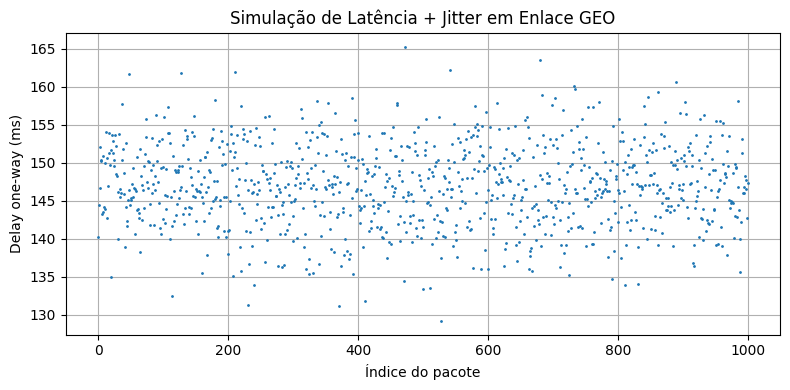

In [4]:
link = GeoSatelliteLink(
    re_km=6378.144,
    sat_altitude_km=35768.0,
    elevation_deg=0.0,
)

# Distâncias
print("=== Distância ===")
print(f"Slant range calculado: {link.d_km:.2f} km\n")

# Latências
one_way = link.one_way_delay_s()
rtt = link.rtt_delay_s()

print("=== Latência ===")
print(f"Atraso de propagação (one-way): {link.propagation_delay_s()*1000:.2f} ms")
print(f"Atraso total one-way (aprox.): {one_way*1000:.2f} ms")
print(f"RTT aproximado: {rtt*1000:.2f} ms\n")

prop_hop_s = link.propagation_delay_s()           # A -> GEO (ou B -> GEO)
prop_AB_s  = 2 * prop_hop_s                       # A -> GEO -> B

one_way_AB_s = prop_AB_s + (link.ground_proc_delay_ms + link.sat_proc_delay_ms)/1000
rtt_AB_s     = 2 * one_way_AB_s

print(f"Atraso propagação A->GEO: {prop_hop_s*1000:.2f} ms")
print(f"Atraso propagação A->GEO->B: {prop_AB_s*1000:.2f} ms")
print(f"Latência one-way A->B (com processamento): {one_way_AB_s*1000:.2f} ms")
print(f"RTT A<->B (aprox.): {rtt_AB_s*1000:.2f} ms\n")


# SNR e BER
snr_db = link.snr_db()
ebn0_db = link.eb_n0_db()
ber = link.ber_bpsk()

print("=== Qualidade de enlace ===")
print(f"FSPL: {link.fspl_db:.2f} dB")
print(f"P_rx: {link.rx_power_dbw():.2f} dBW")
print(f"SNR: {snr_db:.2f} dB")
print(f"Eb/N0: {ebn0_db:.2f} dB")
print(f"BER (BPSK, AWGN): {ber:.3e}\n")

# Jitter (simulação)
delays, avg_delay_s, jitter_s = link.simulate_delays(
    n_packets=1000,
    queue_jitter_std_ms=5.0,
    extra_random_delay_ms=2.0,
    seed=123,
)

print("=== Jitter (simulação) ===")
print(f"Latência média simulada: {avg_delay_s*1000:.2f} ms")
print(f"Jitter (desvio padrão): {jitter_s*1000:.2f} ms\n")

# Custo
cost = link.cost_per_month()
print("=== Custo (modelo simples) ===")
print(f"Custo mensal aproximado: USD {cost:,.2f}")

# Plot opcional dos atrasos (latência + jitter)
plt.figure(figsize=(8, 4))
plt.plot(delays * 1000, ".", markersize=2)
plt.xlabel("Índice do pacote")
plt.ylabel("Delay one-way (ms)")
plt.title("Simulação de Latência + Jitter em Enlace GEO")
plt.grid(True)
plt.tight_layout()
plt.show()

## Instruções de execução

1. Alterar parâmetros no `GeoSatelliteLink(...)` para testar:

   * `bit_rate_bps` (ex.: 5 Mbps, 10 Mbps, 50 Mbps)
   * `tx_power_w`
   * `tx_gain_dbi`, `rx_gain_dbi`
   * `system_noise_temp_k`

2. Coletar:

   * **Latência teórica (one-way, RTT)**
   * **Latência média simulada e jitter**
   * **BER teórico**
   * **Comparar cenários (ex.: mais potência, mais ganho, menos BER)**

## Experimentos

In [69]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcdefaults()

plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

### Experimento 1 – Efeito da Elevação do Satélite

In [5]:
# ----- Experimento 1 -----
elevations = np.linspace(0, 90, 10)
rows = []
for E in elevations:
    link = GeoSatelliteLink(
        re_km=6378.144,
        sat_altitude_km=35768.0,
        elevation_deg=E,
        freq_hz=12e9,
        bandwidth_hz=36e6,
        bit_rate_bps=10e6,
        tx_power_w=20.0,
        tx_gain_dbi=45.0,
        rx_gain_dbi=45.0,
    )
    d = link.d_km
    one_way_ms = link.one_way_delay_s() * 1000
    fspl = link.fspl_db.item()
    snr = link.snr_db().item()
    ebn0 = link.eb_n0_db().item()
    ber = link.ber_bpsk()
    rows.append((E, d, one_way_ms, fspl, snr, ebn0, ber))


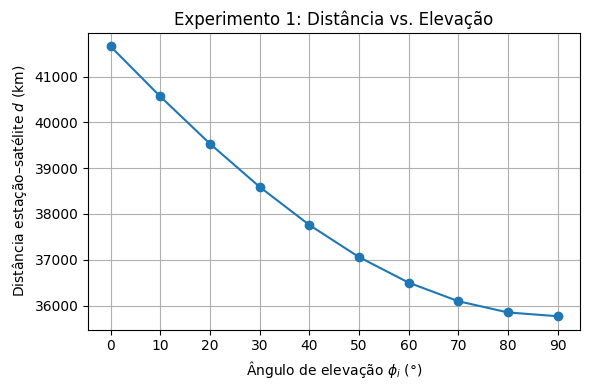

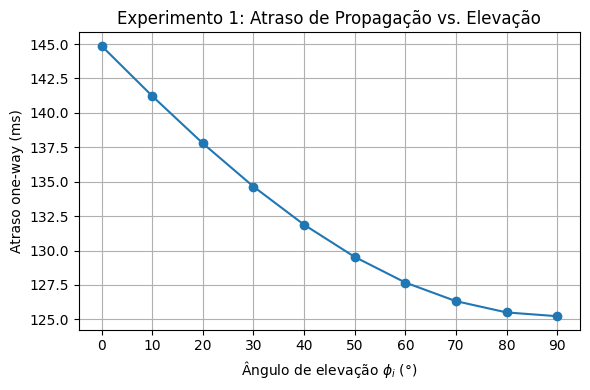

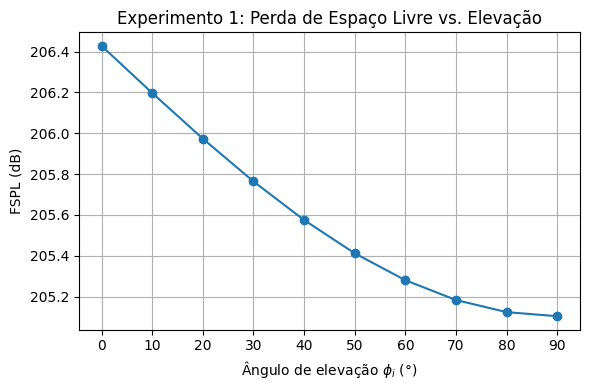

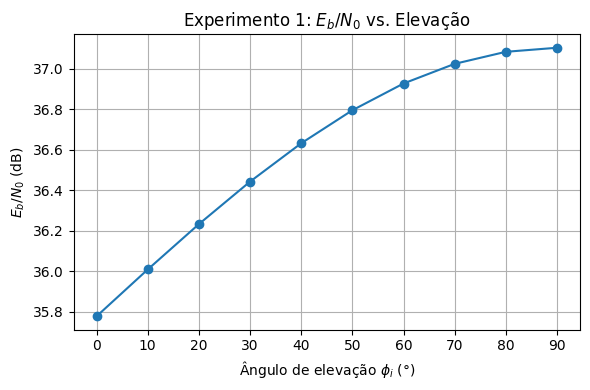

In [ ]:
rows = np.array(rows, dtype=float)
elev   = rows[:, 0]   # phi_i em graus
d_km   = rows[:, 1]
delay  = rows[:, 2]   # one-way em ms
fspl   = rows[:, 3]
snr    = rows[:, 4]
ebn0   = rows[:, 5]
ber    = rows[:, 6]
x_ticks = np.linspace(0, 90, 10)

# -------- Plot 1: distância vs elevação --------
plt.figure(figsize=(6, 4))
plt.plot(elev, d_km, marker="o")
plt.xlabel("Ângulo de elevação $\\phi_i$ (°)")
plt.ylabel("Distância estação–satélite $d$ (km)")
plt.title("Experimento 1: Distância vs. Elevação")
plt.grid(True)
plt.xticks(x_ticks)
plt.tight_layout()
plt.savefig("./plots/exp1_distancia-vs-elevacao.pdf")
plt.show()

# -------- Plot 2: atraso one-way vs elevação --------
plt.figure(figsize=(6, 4))
plt.plot(elev, delay, marker="o")
plt.xlabel("Ângulo de elevação $\\phi_i$ (°)")
plt.ylabel("Atraso one-way (ms)")
plt.title("Experimento 1: Atraso de Propagação vs. Elevação")
plt.grid(True)
plt.tight_layout()
plt.xticks(x_ticks)
plt.savefig("./plots/exp1_atraso1way-vs-elevacao.pdf")
plt.show()

# -------- Plot 3: FSPL vs elevação --------
plt.figure(figsize=(6, 4))
plt.plot(elev, fspl, marker="o")
plt.xlabel("Ângulo de elevação $\\phi_i$ (°)")
plt.ylabel("FSPL (dB)")
plt.title("Experimento 1: Perda de Espaço Livre vs. Elevação")
plt.grid(True)
plt.xticks(x_ticks)
plt.tight_layout()
plt.savefig("./plots/exp1_fpsl-vs-elevacao.pdf")
plt.show()

# -------- Plot 4: Eb/N0 vs elevação --------
plt.figure(figsize=(6, 4))
plt.plot(elev, ebn0, marker="o")
plt.xlabel("Ângulo de elevação $\\phi_i$ (°)")
plt.ylabel("$E_b/N_0$ (dB)")
plt.title("Experimento 1: $E_b/N_0$ vs. Elevação")
plt.grid(True)
plt.xticks(x_ticks)
plt.tight_layout()
plt.savefig("./plots/exp1_ebn0-vs-elevacao.pdf")
plt.show()


### Experimento 2 - Trade-off entre Taxa de Bits e BER

In [7]:
# ----- Experimento 2 -----
bit_rates = [1e6, 5e6, 10e6, 20e6, 50e6]  # 1, 5, 10, 20, 50 Mbps
rows = []
for R in bit_rates:
    link = GeoSatelliteLink(
        elevation_deg=0.0,
        bit_rate_bps=R,
        bandwidth_hz=36e6,
        # demais iguais
    )
    ebn0 = link.eb_n0_db().item()
    ber = link.ber_bpsk()
    rows.append((R/1e6, ebn0, ber))


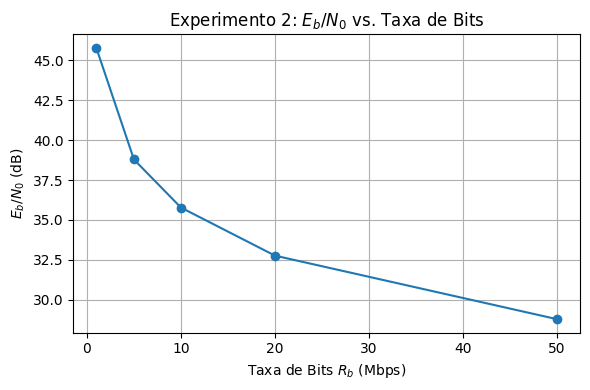

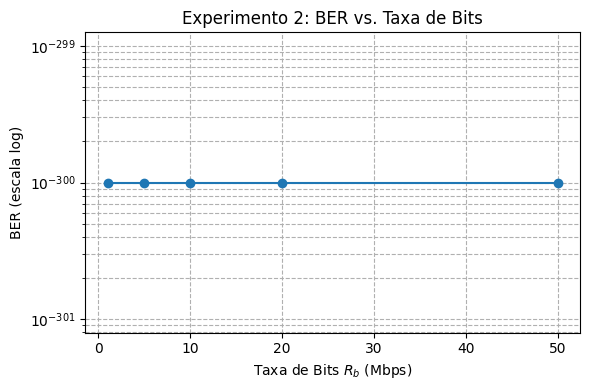

In [ ]:
# Converte para arrays NumPy
rows = np.array(rows, dtype=float)
Rb     = rows[:, 0]
EbN0   = rows[:, 1]
BER    = rows[:, 2]

# -------- Plot 1: Eb/N0 vs Rb --------
plt.figure(figsize=(6, 4))
plt.plot(Rb, EbN0, marker='o')
plt.xlabel("Taxa de Bits $R_b$ (Mbps)")
plt.ylabel("$E_b/N_0$ (dB)")
plt.title("Experimento 2: $E_b/N_0$ vs. Taxa de Bits")
plt.grid(True)
plt.tight_layout()
plt.savefig("./plots/exp2_ebn0-vs-rb.pdf")
plt.show()

# -------- Plot 2: BER vs Rb (escala log) --------
plt.figure(figsize=(6, 4))
plt.semilogy(Rb, BER + 1e-300, marker='o')  # evita erro log de zero
plt.xlabel("Taxa de Bits $R_b$ (Mbps)")
plt.ylabel("BER (escala log)")
plt.title("Experimento 2: BER vs. Taxa de Bits")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig("./plots/exp2_ber-vs-rb.pdf")
plt.show()


### Experimento 3 – Impacto de Degradação (chuva / perdas extras)

In [11]:
# ----- Experimento 3 -----
extra_losses = [0, 3, 6, 10]  # dB
rows = []
for L in extra_losses:
    link = GeoSatelliteLink(
        elevation_deg=0.0,
        other_losses_db=L,
        # demais parâmetros fixos
    )
    snr = link.snr_db().item()
    ebn0 = link.eb_n0_db().item()
    ber = link.ber_bpsk()
    rows.append((L, snr, ebn0, ber))


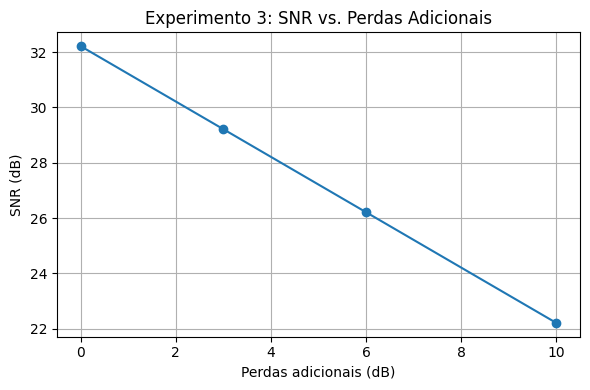

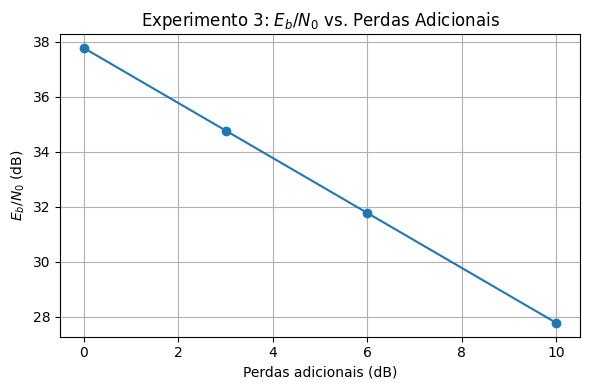

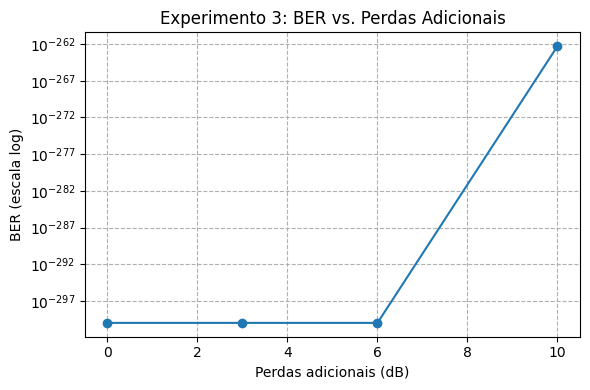

In [12]:
# Converte para arrays NumPy
rows = np.array(rows, dtype=float)
losses = rows[:, 0]
snr    = rows[:, 1]
ebn0   = rows[:, 2]
ber    = rows[:, 3]

# -------- Plot 1: SNR vs perdas --------
plt.figure(figsize=(6, 4))
plt.plot(losses, snr, marker="o")
plt.xlabel("Perdas adicionais (dB)")
plt.ylabel("SNR (dB)")
plt.title("Experimento 3: SNR vs. Perdas Adicionais")
plt.grid(True)
plt.tight_layout()
plt.savefig("./plots/exp3_snr-vs-perdas.pdf")
plt.show()

# -------- Plot 2: Eb/N0 vs perdas --------
plt.figure(figsize=(6, 4))
plt.plot(losses, ebn0, marker="o")
plt.xlabel("Perdas adicionais (dB)")
plt.ylabel("$E_b/N_0$ (dB)")
plt.title("Experimento 3: $E_b/N_0$ vs. Perdas Adicionais")
plt.grid(True)
plt.tight_layout()
plt.savefig("./plots/exp3_ebn0-vs-perdas.pdf")
plt.show()

# -------- Plot 3: BER vs perdas (escala log) --------
plt.figure(figsize=(6, 4))
plt.semilogy(losses, ber + 1e-300, marker="o")  # evita erro log(0)
plt.xlabel("Perdas adicionais (dB)")
plt.ylabel("BER (escala log)")
plt.title("Experimento 3: BER vs. Perdas Adicionais")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig("./plots/exp3_ber-vs-perdas.pdf")
plt.show()
